In [202]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import re

from langdetect import detect
from scipy.stats import f_oneway
from collections import Counter

nltk.download("stopwords", quiet=True)

from nltk.stem.snowball import SpanishStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (
    classification_report,
    f1_score,
    precision_score,
    recall_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
)
from sklearn.linear_model import LogisticRegression

In [203]:
df_data = pd.read_excel(r"datos/Datos_proyecto.xlsx")
df_data.head()

,textos,labels
0,"""Aprendizaje"" y ""educación"" se consideran sinó...",4
1,Para los niños más pequeños (bebés y niños peq...,4
2,"Además, la formación de especialistas en medic...",3
3,En los países de la OCDE se tiende a pasar de ...,4
4,Este grupo se centró en las personas que padec...,3


# 1.1 Calidad de datos

In [204]:
#Completitud

df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2424 entries, 0 to 2423
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   textos  2424 non-null   object
 1   labels  2424 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 38.0+ KB


In [205]:
print("===Count==")
print(df_data.count())
# Valores nulos por columna
print("==Datos Nulos==")
print(df_data.isnull().sum())

print("==Eliminar filas sin texto o etiqueta==")
df = df_data.dropna(subset=["textos", "labels"])
print(df.count())

print("==verificar si hay textos con strings vacíos==")
num_empty = (df["textos"].str.strip() == "").sum()
print("Número de textos vacíos:", num_empty)

print("==Unicidad==")
duplicados = df.duplicated(subset=["textos"])
print(f"Duplicados encontrados: {duplicados.sum()}")

print("== Eliminar duplicados exactos (mismo texto y misma etiqueta ==")
df = df.drop_duplicates(subset=["textos", "labels"])
df.count()


===Count==
textos    2424
labels    2424
dtype: int64
==Datos Nulos==
textos    0
labels    0
dtype: int64
==Eliminar filas sin texto o etiqueta==
textos    2424
labels    2424
dtype: int64
==verificar si hay textos con strings vacíos==
Número de textos vacíos: 0
==Unicidad==
Duplicados encontrados: 0
== Eliminar duplicados exactos (mismo texto y misma etiqueta ==


textos    2424
labels    2424
dtype: int64

In [206]:
# se demora alrededor de 20 segundos
def detect_language(text):
    try:
        return detect(text)
    except:
        return "unknown"


df["language"] = df["textos"].apply(detect_language)

print(len(df[df["language"] != "es"]))

0


In [207]:
# clases en el datset
df["labels"].unique()

array([4, 3, 1], dtype=int64)

In [208]:
df = df.drop(columns=["language"])

In [209]:
df["word_count"] = df["textos"].apply(lambda x: len(str(x).split()))

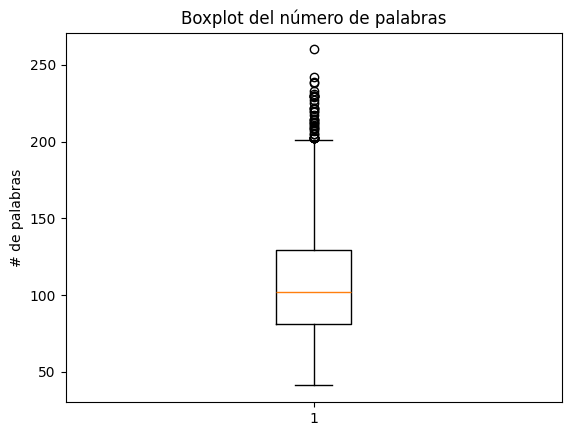

In [210]:
plt.boxplot(df["word_count"])
plt.title("Boxplot del número de palabras")
plt.ylabel("# de palabras")
plt.show()

In [211]:
wpt = nltk.WordPunctTokenizer()
stop_words = set(nltk.corpus.stopwords.words("spanish"))

spanish_stemmer = SpanishStemmer()


def tokenize_text(text, stem=True):
    # Elimina caracteres especiales y espacios en blanco
    doc = re.sub(r"[^A-Za-zÁÉÍÓÚáéíóúÜüÑñ\s]", "", text, flags=re.U)  # Unicode aware
    doc = doc.lower()
    doc = doc.strip()
    # Tokenizar documento
    tokens = wpt.tokenize(doc)
    # Filtrar palabras
    filtered_tokens = [
        spanish_stemmer.stem(token) if stem else token
        for token in tokens
        if token not in stop_words
    ]
    # Recrear documento de texto
    doc = " ".join(filtered_tokens)
    return doc, filtered_tokens


normalized_df = df.copy()
normalized_df[["tokenized_text", "tokens"]] = normalized_df["textos"].apply(
    lambda x: pd.Series(tokenize_text(x, stem=False))
)

# recalcular word_count
normalized_df["word_count"] = normalized_df["textos"].apply(
    lambda x: len(str(x).split())
)

In [212]:
normalized_df.head()

,textos,labels,word_count,tokenized_text,tokens
0,"""Aprendizaje"" y ""educación"" se consideran sinó...",4,48,aprendizaje educación consideran sinónimos esc...,"[aprendizaje, educación, consideran, sinónimos..."
1,Para los niños más pequeños (bebés y niños peq...,4,72,niños pequeños bebés niños pequeños capacitaci...,"[niños, pequeños, bebés, niños, pequeños, capa..."
2,"Además, la formación de especialistas en medic...",3,93,además formación especialistas medicina genera...,"[además, formación, especialistas, medicina, g..."
3,En los países de la OCDE se tiende a pasar de ...,4,109,países ocde tiende pasar cursos obligatorios o...,"[países, ocde, tiende, pasar, cursos, obligato..."
4,Este grupo se centró en las personas que padec...,3,94,grupo centró personas padecen trastornos menta...,"[grupo, centró, personas, padecen, trastornos,..."


In [213]:
# 9. Distribución de etiquetas
print("Distribución de clases:")
dist_df = pd.DataFrame(
    {
        "cantidad": df["labels"].value_counts(),
        "porcentaje": round(df["labels"].value_counts() / len(df), 2),
    }
)
print(dist_df)

Distribución de clases:
        cantidad  porcentaje
labels                      
4           1025        0.42
3            894        0.37
1            505        0.21


In [214]:
colors = {1: "#1D8F97", 3: "#9bd137", 4: "#DA2C38"}

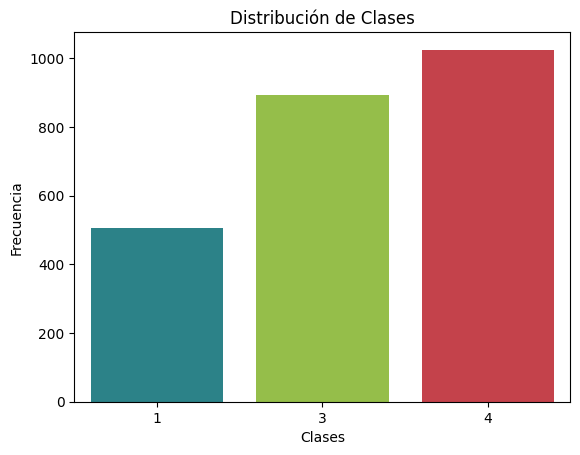

In [215]:
value_counts = df["labels"].value_counts()
x_values = value_counts.index
y_values = value_counts.values

sns.barplot(x=x_values, y=y_values, palette=colors, hue=x_values, legend=False)

plt.title("Distribución de Clases")
plt.xlabel("Clases")
plt.ylabel("Frecuencia")
plt.show()

In [216]:
X = normalized_df["tokenized_text"]
y = normalized_df["labels"]
X_train_text, X_test_text, y_train, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42
)

In [217]:
vectorizer_ngram = CountVectorizer(ngram_range=(1, 1))
X_train = vectorizer_ngram.fit_transform(X_train_text.fillna(""))
X_test = vectorizer_ngram.transform(X_test_text.fillna(""))

best_model = LogisticRegression(max_iter=1000, random_state=42)

best_model.fit(X_train, y_train)

y_preds = best_model.predict(X_test)

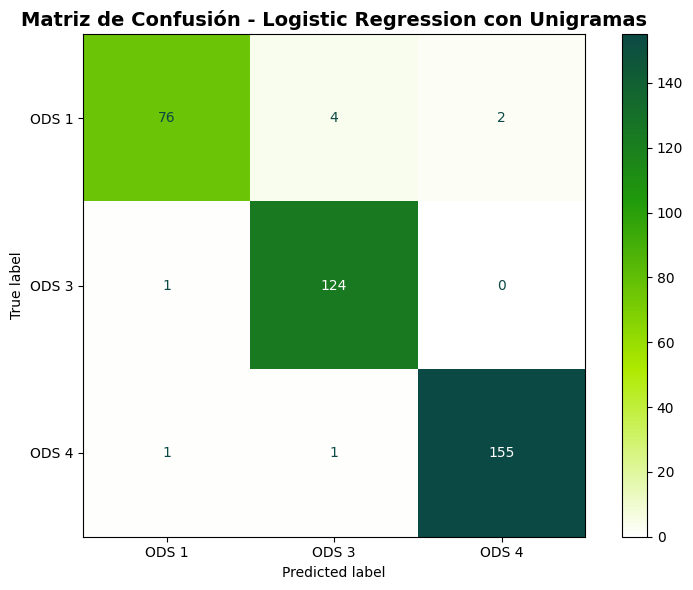

In [218]:

from matplotlib.colors import LinearSegmentedColormap

# Crear colormap personalizado con los colores especificados que se usan en la ppt
colors = ['#FFFFFF', '#AEEA00', '#219A0B', '#0B4944']
custom_cmap = LinearSegmentedColormap.from_list('custom', colors, N=256)

cm = confusion_matrix(y_test, y_preds)

# Visualización 1: Usando ConfusionMatrixDisplay de sklearn
fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm, display_labels=["ODS 1", "ODS 3", "ODS 4"]
)
disp.plot(cmap=custom_cmap, values_format="d", ax=ax)
plt.title(
    "Matriz de Confusión - Logistic Regression con Unigramas",
    fontsize=14,
    fontweight="bold",
)
plt.tight_layout()
plt.show()

In [219]:
from sklearn.model_selection import cross_val_score

# validación cruzada con 10 folds
cv_scores_f1 = cross_val_score(best_model, X_train, y_train, cv=10, scoring='f1_macro')
cv_scores_precision = cross_val_score(best_model, X_train, y_train, cv=10, scoring='precision_macro')
cv_scores_recall = cross_val_score(best_model, X_train, y_train, cv=10, scoring='recall_macro')

print("10-Fold Cross Validation Results:")
print(f"F1-Score: {cv_scores_f1.mean():.4f} (+/- {cv_scores_f1.std() * 2:.4f})")
print(f"Precision: {cv_scores_precision.mean():.4f} (+/- {cv_scores_precision.std() * 2:.4f})")
print(f"Recall: {cv_scores_recall.mean():.4f} (+/- {cv_scores_recall.std() * 2:.4f})")

10-Fold Cross Validation Results:
F1-Score: 0.9715 (+/- 0.0273)
Precision: 0.9748 (+/- 0.0248)
Recall: 0.9687 (+/- 0.0303)


# Validación nuevos Datos

In [220]:
df_data_2 = pd.read_excel(r"datos/Datos_etapa 2.xlsx")
df_data_2.head()

,textos,labels
0,La definición de privación está basada en el m...,1
1,La mayoría de los programas de protección soci...,1
2,Esto es dos veces y media mayor que la partici...,1
3,El enfoque aquí está en los aspectos de la pob...,1
4,El factor educativo representa una mayor contr...,1


In [221]:
#Completitud

df_data_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99 entries, 0 to 98
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   textos  99 non-null     object
 1   labels  99 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.7+ KB


In [222]:
print("===Count==")
print(df_data_2.count())
# Valores nulos por columna
print("==Datos Nulos==")
print(df_data_2.isnull().sum())

print("==Eliminar filas sin texto o etiqueta==")
df = df_data_2.dropna(subset=["textos", "labels"])
print(df.count())

print("==verificar si hay textos con strings vacíos==")
num_empty = (df["textos"].str.strip() == "").sum()
print("Número de textos vacíos:", num_empty)

print("==Unicidad==")
duplicados = df.duplicated(subset=["textos"])
print(f"Duplicados encontrados: {duplicados.sum()}")

print("== Eliminar duplicados exactos (mismo texto y misma etiqueta ==")
df = df.drop_duplicates(subset=["textos", "labels"])
df.count()


===Count==
textos    99
labels    99
dtype: int64
==Datos Nulos==
textos    0
labels    0
dtype: int64
==Eliminar filas sin texto o etiqueta==
textos    99
labels    99
dtype: int64
==verificar si hay textos con strings vacíos==
Número de textos vacíos: 0
==Unicidad==
Duplicados encontrados: 0
== Eliminar duplicados exactos (mismo texto y misma etiqueta ==


textos    99
labels    99
dtype: int64

In [223]:
# se demora alrededor de 20 segundos
def detect_language(text):
    try:
        return detect(text)
    except:
        return "unknown"


df["language"] = df["textos"].apply(detect_language)

print(len(df[df["language"] != "es"]))

0


In [224]:
# clases en el datset
df["labels"].unique()

array([1, 3, 4], dtype=int64)

In [225]:
df = df.drop(columns=["language"])

In [226]:
normalized_df = df.copy()
normalized_df[["tokenized_text", "tokens"]] = normalized_df["textos"].apply(
    lambda x: pd.Series(tokenize_text(x, stem=False))
)

# recalcular word_count
normalized_df["word_count"] = normalized_df["textos"].apply(
    lambda x: len(str(x).split())
)

In [227]:
normalized_df.head()

,textos,labels,tokenized_text,tokens,word_count
0,La definición de privación está basada en el m...,1,definición privación basada marco derechos niñ...,"[definición, privación, basada, marco, derecho...",100
1,La mayoría de los programas de protección soci...,1,mayoría programas protección social ghana aspi...,"[mayoría, programas, protección, social, ghana...",97
2,Esto es dos veces y media mayor que la partici...,1,dos veces media mayor participación correspond...,"[dos, veces, media, mayor, participación, corr...",61
3,El enfoque aquí está en los aspectos de la pob...,1,enfoque aquí aspectos pobreza reflejan situaci...,"[enfoque, aquí, aspectos, pobreza, reflejan, s...",80
4,El factor educativo representa una mayor contr...,1,factor educativo representa mayor contribución...,"[factor, educativo, representa, mayor, contrib...",58


In [228]:
# 9. Distribución de etiquetas
print("Distribución de clases:")
dist_df = pd.DataFrame(
    {
        "cantidad": df["labels"].value_counts(),
        "porcentaje": round(df["labels"].value_counts() / len(df), 2),
    }
)
print(dist_df)

Distribución de clases:
        cantidad  porcentaje
labels                      
4             43        0.43
3             35        0.35
1             21        0.21


In [229]:
colors = {1: "#1D8F97", 3: "#9bd137", 4: "#DA2C38"}

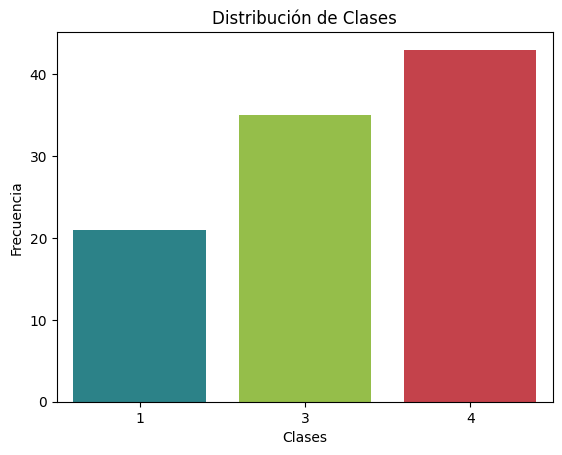

In [230]:
value_counts = df["labels"].value_counts()
x_values = value_counts.index
y_values = value_counts.values

sns.barplot(x=x_values, y=y_values, palette=colors, hue=x_values, legend=False)

plt.title("Distribución de Clases")
plt.xlabel("Clases")
plt.ylabel("Frecuencia")
plt.show()

In [231]:
X_test

<364x12940 sparse matrix of type '<class 'numpy.int64'>'
	with 15792 stored elements in Compressed Sparse Row format>

In [234]:
X = normalized_df["tokenized_text"]
y = normalized_df["labels"]
X_test = X.copy()
y_test = y.copy()
# Ahora sí transformar el test (usar la variable correcta)
X_test = vectorizer_ngram.transform(X_test.fillna(""))

# Predecir con el modelo ya entrenado
y_preds = best_model.predict(X_test)

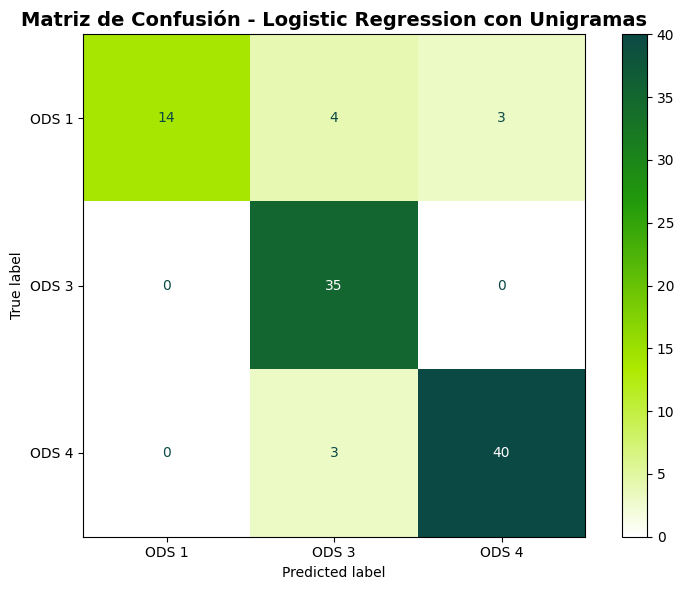

In [235]:

from matplotlib.colors import LinearSegmentedColormap

# Crear colormap personalizado con los colores especificados que se usan en la ppt
colors = ['#FFFFFF', '#AEEA00', '#219A0B', '#0B4944']
custom_cmap = LinearSegmentedColormap.from_list('custom', colors, N=256)
cm = confusion_matrix(y_test, y_preds)

# Visualización 1: Usando ConfusionMatrixDisplay de sklearn
fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm, display_labels=["ODS 1", "ODS 3", "ODS 4"]
)
disp.plot(cmap=custom_cmap, values_format="d", ax=ax)
plt.title(
    "Matriz de Confusión - Logistic Regression con Unigramas",
    fontsize=14,
    fontweight="bold",
)
plt.tight_layout()
plt.show()

In [239]:
print(f"Precision (macro): {precision_score(y_test, y_preds, average='macro', zero_division=0):.4f}")
print(f"Recall    (macro): {recall_score(y_test, y_preds, average='macro', zero_division=0):.4f}")
print(f"F1-score  (macro): {f1_score(y_test, y_preds, average='macro', zero_division=0):.4f}")
print(f"Precision (weighted): {precision_score(y_test, y_preds, average='weighted', zero_division=0):.4f}")
print(f"Recall    (weighted): {recall_score(y_test, y_preds, average='weighted', zero_division=0):.4f}")
print(f"F1-score  (weighted): {f1_score(y_test, y_preds, average='weighted', zero_division=0):.4f}")


Precision (macro): 0.9212
Recall    (macro): 0.8656
F1-score  (macro): 0.8798
Precision (weighted): 0.9108
Recall    (weighted): 0.8990
F1-score  (weighted): 0.8951


# Creación de datos sintéticos

In [244]:
from pathlib import Path
import sys, site, platform, os, subprocess

# cargar dotenv (instala python-dotenv si hace falta)
try:
    from dotenv import load_dotenv
    load_dotenv()   # carga .env desde el working dir o sus padres
except Exception:
    pass

secret = os.getenv("OPENAI_API_KEY")
if not secret:
    raise RuntimeError(
        "OPENAI_API_KEY no encontrada. Verifica .env en la ruta y que tenga formato: OPENAI_API_KEY=sk-... (sin comillas)"
    )

# No imprimir la clave. Verificar solo que se cargó:
print("OPENAI_API_KEY cargada correctamente:", bool(secret))

OPENAI_API_KEY cargada correctamente: True


In [245]:
print("Python exe:", sys.executable)
print("Version:", sys.version)
print("Site-packages:", site.getsitepackages() if hasattr(site,"getsitepackages") else site.getusersitepackages())
print("OS:", platform.platform())

Python exe: c:\Users\aleja\anaconda3\envs\bi\python.exe
Version: 3.12.9 | packaged by conda-forge | (main, Mar  4 2025, 22:37:18) [MSC v.1943 64 bit (AMD64)]
Site-packages: ['c:\\Users\\aleja\\anaconda3\\envs\\bi', 'c:\\Users\\aleja\\anaconda3\\envs\\bi\\Lib\\site-packages']
OS: Windows-11-10.0.26100-SP0


In [247]:
from openai import OpenAI
client = OpenAI(api_key=secret)
models = client.models.list()
print("OK SDK v1.x, modelos:", len(models.data))

OK SDK v1.x, modelos: 96


In [257]:
RUTA = "datos/Datos_proyecto.xlsx"  # ajusta si tu ruta es otra
TEXTO = "textos"  # columna de la opinión
ODS = "labels"  # columna de etiqueta 1,3,4

In [258]:
df = pd.read_excel(RUTA)

In [270]:
# ...existing code...
# Reemplaza la sección de generación sintética por esto
import time
import json
from math import ceil

# parámetros: cuántas nuevas filas quieres POR CLASE
targets = {1: 520, 3: 131}  # clase: cantidad a generar

# columnas clave
cols = ["textos", "labels"]
df_before = df[cols].drop_duplicates().copy()

# semillas por clase para "inspirar" al modelo (hasta 8 ejemplos)
def get_seeds_for_class(df, clase, n=8):
    s = (
        df[df[ODS] == clase][TEXTO]
        .dropna()
        .astype(str)
        .sample(min(n, sum(df[ODS] == clase)), random_state=42)
        .tolist()
    )
    return s

# función que llama al API pidiendo `n` ejemplos JSON para la clase `clase`
def request_examples(client, clase, seeds, n_to_generate, model="gpt-4o-mini", max_attempts=3):
    prompt = f"""
Genera {n_to_generate} opiniones ciudadanas breves (1–2 oraciones) en español (Colombia), realistas y respetuosas, sobre problemáticas locales que correspondan al ODS {clase}.
Requisitos estrictos:
- TODAS deben mapear exclusivamente al ODS {clase}.
- Varía zona (urbano/rural), actores e instituciones; evita datos personales y contenido sensible.
- Mantén neutralidad política.
- Entrega SOLO JSON válido: una lista de objetos con exactamente estas llaves:
  "textos" (string) y "labels" (entero {clase})
- No envíes explicaciones, encabezados ni bloques de código; solo el JSON.
- Evita duplicados exactos de los ejemplos provistos.
Ejemplos de inspiración (no copiar textualmente, solo estilo):
{chr(10).join(f"- {s}" for s in seeds) if seeds else "- (sin ejemplos de contexto)"}
    """
    for attempt in range(max_attempts):
        try:
            response = client.chat.completions.create(
                model=model,
                messages=[
                    {"role": "system", "content": "Eres un generador de datos sintéticos."},
                    {"role": "user", "content": prompt},
                ],
                temperature=0.7,
            )
            raw = response.choices[0].message.content
            txt = raw.strip()
            # limpiar posibles fences
            if txt.startswith("```"):
                txt = txt.strip("`")
                if "\n" in txt:
                    txt = txt.split("\n", 1)[1]
            data = json.loads(txt)
            # validar forma esperada
            valid = []
            for item in data:
                if isinstance(item, dict) and "textos" in item and "labels" in item:
                    item["labels"] = int(item["labels"])
                    valid.append({"textos": str(item["textos"]).strip(), "labels": item["labels"]})
            return pd.DataFrame(valid)
        except Exception as e:
            # pequeño backoff
            time.sleep(1 + attempt * 2)
    # si falla, devuelve vacío
    return pd.DataFrame(columns=cols)

# loop por cada clase objetivo, generando en lotes de tamaño batch_size
batch_size = 20  # generación por llamada (ajustable)
added_summary = {}

for clase, needed in targets.items():
    added = 0
    seeds = get_seeds_for_class(df, clase, n=8)
    iterations = ceil(needed / batch_size)
    for i in range(iterations):
        remaining = needed - added
        if remaining <= 0:
            break
        to_request = min(batch_size, remaining)
        df_batch = request_examples(client, clase, seeds, to_request)
        if df_batch.empty:
            print(f"[WARN] No se obtuvo respuesta válida para clase {clase} en la iteración {i+1}.")
            continue
        # forzar label correcto por si modelo se equivoca
        df_batch["labels"] = clase
        # mantener solo columnas necesarias y deduplicar contra df actual
        df_batch = df_batch[cols].dropna().drop_duplicates()
        # unir y eliminar duplicados
        prev_len = len(df)
        df = pd.concat([df, df_batch], ignore_index=True)
        df = df.drop_duplicates(subset=cols).reset_index(drop=True)
        new_added_now = len(df) - prev_len
        added += new_added_now
        print(f"Clase {clase}: intento {i+1}/{iterations} -> solicitados {to_request}, agregados netos {new_added_now}, total agregados {added}/{needed}")
        time.sleep(0.5)  # evitar ráfagas rápidas
        # actualizar seeds (opcional): añadir algunas muestras nuevas para variar la siguiente llamada
        seeds = list(pd.unique((seeds + df_batch[TEXTO].astype(str).tolist())))[-8:]
    added_summary[clase] = added

# reporte final y filas nuevas
added_rows = df.merge(df_before, on=cols, how="left", indicator=True).loc[lambda x: x["_merge"] == "left_only", cols]
print("Resumen agregado por clase:", added_summary)
print("Nuevas filas agregadas totales:", len(added_rows))
display(added_rows)
# ...existing code...

Clase 1: intento 1/26 -> solicitados 20, agregados netos 20, total agregados 20/520


C:\Users\aleja\AppData\Local\Temp\ipykernel_3588\3308177165.py:101: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  seeds = list(pd.unique((seeds + df_batch[TEXTO].astype(str).tolist())))[-8:]


Clase 1: intento 2/26 -> solicitados 20, agregados netos 20, total agregados 40/520


C:\Users\aleja\AppData\Local\Temp\ipykernel_3588\3308177165.py:101: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  seeds = list(pd.unique((seeds + df_batch[TEXTO].astype(str).tolist())))[-8:]


Clase 1: intento 3/26 -> solicitados 20, agregados netos 20, total agregados 60/520


C:\Users\aleja\AppData\Local\Temp\ipykernel_3588\3308177165.py:101: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  seeds = list(pd.unique((seeds + df_batch[TEXTO].astype(str).tolist())))[-8:]


Clase 1: intento 4/26 -> solicitados 20, agregados netos 20, total agregados 80/520


C:\Users\aleja\AppData\Local\Temp\ipykernel_3588\3308177165.py:101: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  seeds = list(pd.unique((seeds + df_batch[TEXTO].astype(str).tolist())))[-8:]


Clase 1: intento 5/26 -> solicitados 20, agregados netos 20, total agregados 100/520


C:\Users\aleja\AppData\Local\Temp\ipykernel_3588\3308177165.py:101: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  seeds = list(pd.unique((seeds + df_batch[TEXTO].astype(str).tolist())))[-8:]


Clase 1: intento 6/26 -> solicitados 20, agregados netos 20, total agregados 120/520


C:\Users\aleja\AppData\Local\Temp\ipykernel_3588\3308177165.py:101: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  seeds = list(pd.unique((seeds + df_batch[TEXTO].astype(str).tolist())))[-8:]


Clase 1: intento 7/26 -> solicitados 20, agregados netos 20, total agregados 140/520


C:\Users\aleja\AppData\Local\Temp\ipykernel_3588\3308177165.py:101: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  seeds = list(pd.unique((seeds + df_batch[TEXTO].astype(str).tolist())))[-8:]


Clase 1: intento 8/26 -> solicitados 20, agregados netos 20, total agregados 160/520


C:\Users\aleja\AppData\Local\Temp\ipykernel_3588\3308177165.py:101: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  seeds = list(pd.unique((seeds + df_batch[TEXTO].astype(str).tolist())))[-8:]


Clase 1: intento 9/26 -> solicitados 20, agregados netos 20, total agregados 180/520


C:\Users\aleja\AppData\Local\Temp\ipykernel_3588\3308177165.py:101: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  seeds = list(pd.unique((seeds + df_batch[TEXTO].astype(str).tolist())))[-8:]


Clase 1: intento 10/26 -> solicitados 20, agregados netos 20, total agregados 200/520


C:\Users\aleja\AppData\Local\Temp\ipykernel_3588\3308177165.py:101: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  seeds = list(pd.unique((seeds + df_batch[TEXTO].astype(str).tolist())))[-8:]


Clase 1: intento 11/26 -> solicitados 20, agregados netos 20, total agregados 220/520


C:\Users\aleja\AppData\Local\Temp\ipykernel_3588\3308177165.py:101: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  seeds = list(pd.unique((seeds + df_batch[TEXTO].astype(str).tolist())))[-8:]


Clase 1: intento 12/26 -> solicitados 20, agregados netos 20, total agregados 240/520


C:\Users\aleja\AppData\Local\Temp\ipykernel_3588\3308177165.py:101: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  seeds = list(pd.unique((seeds + df_batch[TEXTO].astype(str).tolist())))[-8:]


Clase 1: intento 13/26 -> solicitados 20, agregados netos 20, total agregados 260/520


C:\Users\aleja\AppData\Local\Temp\ipykernel_3588\3308177165.py:101: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  seeds = list(pd.unique((seeds + df_batch[TEXTO].astype(str).tolist())))[-8:]


Clase 1: intento 14/26 -> solicitados 20, agregados netos 20, total agregados 280/520


C:\Users\aleja\AppData\Local\Temp\ipykernel_3588\3308177165.py:101: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  seeds = list(pd.unique((seeds + df_batch[TEXTO].astype(str).tolist())))[-8:]


Clase 1: intento 15/26 -> solicitados 20, agregados netos 20, total agregados 300/520


C:\Users\aleja\AppData\Local\Temp\ipykernel_3588\3308177165.py:101: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  seeds = list(pd.unique((seeds + df_batch[TEXTO].astype(str).tolist())))[-8:]


Clase 1: intento 16/26 -> solicitados 20, agregados netos 20, total agregados 320/520


C:\Users\aleja\AppData\Local\Temp\ipykernel_3588\3308177165.py:101: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  seeds = list(pd.unique((seeds + df_batch[TEXTO].astype(str).tolist())))[-8:]


Clase 1: intento 17/26 -> solicitados 20, agregados netos 20, total agregados 340/520


C:\Users\aleja\AppData\Local\Temp\ipykernel_3588\3308177165.py:101: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  seeds = list(pd.unique((seeds + df_batch[TEXTO].astype(str).tolist())))[-8:]


Clase 1: intento 18/26 -> solicitados 20, agregados netos 20, total agregados 360/520


C:\Users\aleja\AppData\Local\Temp\ipykernel_3588\3308177165.py:101: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  seeds = list(pd.unique((seeds + df_batch[TEXTO].astype(str).tolist())))[-8:]


Clase 1: intento 19/26 -> solicitados 20, agregados netos 20, total agregados 380/520


C:\Users\aleja\AppData\Local\Temp\ipykernel_3588\3308177165.py:101: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  seeds = list(pd.unique((seeds + df_batch[TEXTO].astype(str).tolist())))[-8:]


Clase 1: intento 20/26 -> solicitados 20, agregados netos 20, total agregados 400/520


C:\Users\aleja\AppData\Local\Temp\ipykernel_3588\3308177165.py:101: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  seeds = list(pd.unique((seeds + df_batch[TEXTO].astype(str).tolist())))[-8:]


Clase 1: intento 21/26 -> solicitados 20, agregados netos 20, total agregados 420/520


C:\Users\aleja\AppData\Local\Temp\ipykernel_3588\3308177165.py:101: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  seeds = list(pd.unique((seeds + df_batch[TEXTO].astype(str).tolist())))[-8:]


Clase 1: intento 22/26 -> solicitados 20, agregados netos 20, total agregados 440/520


C:\Users\aleja\AppData\Local\Temp\ipykernel_3588\3308177165.py:101: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  seeds = list(pd.unique((seeds + df_batch[TEXTO].astype(str).tolist())))[-8:]


Clase 1: intento 23/26 -> solicitados 20, agregados netos 20, total agregados 460/520


C:\Users\aleja\AppData\Local\Temp\ipykernel_3588\3308177165.py:101: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  seeds = list(pd.unique((seeds + df_batch[TEXTO].astype(str).tolist())))[-8:]


Clase 1: intento 24/26 -> solicitados 20, agregados netos 20, total agregados 480/520


C:\Users\aleja\AppData\Local\Temp\ipykernel_3588\3308177165.py:101: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  seeds = list(pd.unique((seeds + df_batch[TEXTO].astype(str).tolist())))[-8:]


Clase 1: intento 25/26 -> solicitados 20, agregados netos 20, total agregados 500/520


C:\Users\aleja\AppData\Local\Temp\ipykernel_3588\3308177165.py:101: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  seeds = list(pd.unique((seeds + df_batch[TEXTO].astype(str).tolist())))[-8:]


Clase 1: intento 26/26 -> solicitados 20, agregados netos 20, total agregados 520/520


C:\Users\aleja\AppData\Local\Temp\ipykernel_3588\3308177165.py:101: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  seeds = list(pd.unique((seeds + df_batch[TEXTO].astype(str).tolist())))[-8:]


Clase 3: intento 1/7 -> solicitados 20, agregados netos 19, total agregados 19/131


C:\Users\aleja\AppData\Local\Temp\ipykernel_3588\3308177165.py:101: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  seeds = list(pd.unique((seeds + df_batch[TEXTO].astype(str).tolist())))[-8:]


Clase 3: intento 2/7 -> solicitados 20, agregados netos 20, total agregados 39/131


C:\Users\aleja\AppData\Local\Temp\ipykernel_3588\3308177165.py:101: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  seeds = list(pd.unique((seeds + df_batch[TEXTO].astype(str).tolist())))[-8:]


Clase 3: intento 3/7 -> solicitados 20, agregados netos 20, total agregados 59/131


C:\Users\aleja\AppData\Local\Temp\ipykernel_3588\3308177165.py:101: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  seeds = list(pd.unique((seeds + df_batch[TEXTO].astype(str).tolist())))[-8:]


Clase 3: intento 4/7 -> solicitados 20, agregados netos 20, total agregados 79/131


C:\Users\aleja\AppData\Local\Temp\ipykernel_3588\3308177165.py:101: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  seeds = list(pd.unique((seeds + df_batch[TEXTO].astype(str).tolist())))[-8:]


Clase 3: intento 5/7 -> solicitados 20, agregados netos 20, total agregados 99/131


C:\Users\aleja\AppData\Local\Temp\ipykernel_3588\3308177165.py:101: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  seeds = list(pd.unique((seeds + df_batch[TEXTO].astype(str).tolist())))[-8:]


Clase 3: intento 6/7 -> solicitados 20, agregados netos 20, total agregados 119/131


C:\Users\aleja\AppData\Local\Temp\ipykernel_3588\3308177165.py:101: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  seeds = list(pd.unique((seeds + df_batch[TEXTO].astype(str).tolist())))[-8:]


Clase 3: intento 7/7 -> solicitados 12, agregados netos 12, total agregados 131/131
Resumen agregado por clase: {1: 520, 3: 131}
Nuevas filas agregadas totales: 651


C:\Users\aleja\AppData\Local\Temp\ipykernel_3588\3308177165.py:101: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  seeds = list(pd.unique((seeds + df_batch[TEXTO].astype(str).tolist())))[-8:]


,textos,labels
2444,"En nuestra comunidad rural, el acceso a progra...",1
2445,El aumento del desempleo en la ciudad ha lleva...,1
2446,La falta de oportunidades laborales en las zon...,1
2447,Es preocupante ver cómo muchas familias en nue...,1
2448,"Los subsidios de vivienda son una gran ayuda, ...",1
...,...,...
3090,Las personas con enfermedades crónicas enfrent...,3
3091,La salud mental en las zonas urbanas no recibe...,3
3092,La creciente contaminación del aire en la ciud...,3
3093,El transporte público no es accesible para per...,3


In [272]:
print(len(df))

3095


In [279]:
(df["labels"]==1).sum()

1045

In [274]:
print(f"Tokens usados en el prompt: {response.usage.prompt_tokens}")
print(f"Tokens usados en la respuesta: {response.usage.completion_tokens}")
print(f"Tokens usados en total: {response.usage.total_tokens}")

Tokens usados en el prompt: 1197
Tokens usados en la respuesta: 743
Tokens usados en total: 1940


In [281]:
# 9. Distribución de etiquetas
print("Distribución de clases:")
dist_df = pd.DataFrame(
    {
        "cantidad": df["labels"].value_counts(),
        "porcentaje": round(df["labels"].value_counts() / len(df), 2),
    }
)
print(dist_df)

Distribución de clases:
        cantidad  porcentaje
labels                      
1           1045        0.34
4           1025        0.33
3           1025        0.33


In [282]:
colors = {1: "#1D8F97", 3: "#9bd137", 4: "#DA2C38"}

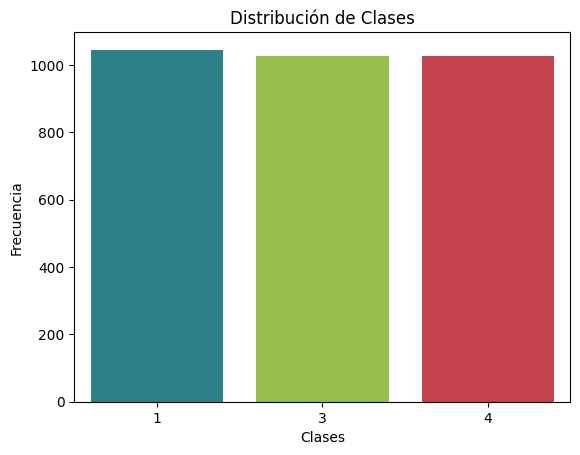

In [283]:
value_counts = df["labels"].value_counts()
x_values = value_counts.index
y_values = value_counts.values

sns.barplot(x=x_values, y=y_values, palette=colors, hue=x_values, legend=False)

plt.title("Distribución de Clases")
plt.xlabel("Clases")
plt.ylabel("Frecuencia")
plt.show()

In [285]:
df.to_excel(r"datos/Datos_aumentados.xlsx", index=False)